This notebook demonstrates how to use DART, and tests that the outputed similarity measurements are expected, using two simulated datasets.
Both datasets include three categorical variables (Population, Device Manufacturer, and Disease Status) and one numeric attribute (Age). 
The [first dataset](#test-1-single-population-attribute-skew) has one relatively well distributed population and one with several skewed attribute distributions.
The [second dataset](#test-2-double-population-attribute-skew) features two distributional skews in both populations.

## Contents:
  - [Test 1: single population attribute skew](#test-1-single-population-attribute-skew)
    - [Histogram analysis](#hist-1)
      - [Population-level distributions](#pop-1)
      - [Joint distributions](#joint-1)
    - [Distributional similarity with DART](#dart-1)
  - [Test 2: double population attribute skew](#test-2-double-population-attribute-skew)
    - [Histogram analysis](#hist-2)
      - [Population-level distributions](#pop-2)
      - [Joint distributions](#joint-2)
    - [Distributional similarity with DART](#dart-2)

# Test 1: single population attribute skew
This dataset was generated to simulate a scenario in which the data describing a population ("Population A") was gathered to be used as an approximation of a different population ("Population B").
However, Population A only is only a good approximation of Population B with respect to the attribute distributions of the overall populations; the joint distributions of multiple attributes differs substantially between populations.

This test will demonstrate that:
  - Typical histogram-based distributional similarity assessment can miss important dissimilarities only evident in joint distribution analysis
  - DART distribution similarity analysis provides quantitative indication of distributional dissimilarities for joint distributions of two or more attributes

In [2]:
# needed imports
import DART
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

DART.parameters["random_state"] = 1337 # ensures that numbers exactly match the version of the test notebook on GitHub
sns.set_style("whitegrid")

In [3]:
# read in example data
data = pd.read_csv("simulated_datasets/single_population_skew.csv")
# ensure that categorical variables are always shown in the same order in plots
data["Device Manufacturer"] = pd.Categorical(data["Device Manufacturer"], ["i", "ii", "iii", "iv"])
data["Population"] = pd.Categorical(data["Population"], ["A","B"])
data["Disease Status"] = pd.Categorical(data["Disease Status"], ["positive", "negative"])
data.head()

,Population,Device Manufacturer,Disease Status,Age
0,A,ii,positive,79
1,A,ii,negative,39
2,A,ii,positive,91
3,A,iv,positive,85
4,A,iv,positive,92


## Histogram analysis<a id="hist-1"></a>

### Population-level distributions<a id="pop-1"></a>

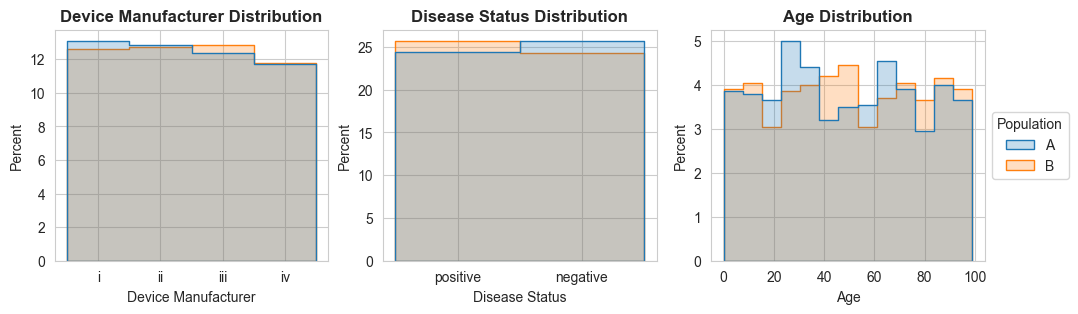

In [4]:
# look at attribute distributions
attributes = [attribute for attribute in data.columns if attribute != "Population"]
fig, axes = plt.subplots(1, len(attributes), figsize=(12,3))
for ii, attribute in enumerate(attributes):
    sns.histplot(data=data, x=attribute, hue="Population", element="step", ax=axes[ii], stat="percent")
    axes[ii].set_title(f"{attribute} Distribution", fontweight="bold")
# only show the legend once
sns.move_legend(axes[-1], "center left", bbox_to_anchor=(1,0.5))
for i in range(len(attributes)-1):
    axes[i].get_legend().remove()

### Joint distributions<a id="joint-1"></a>

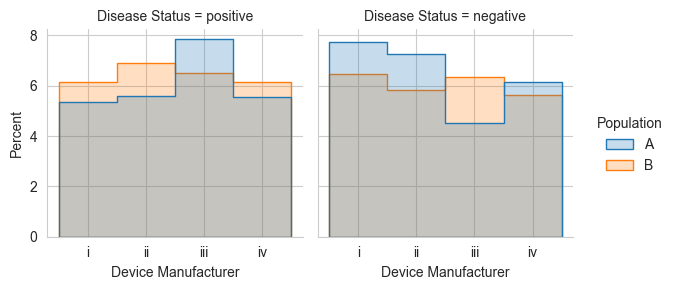

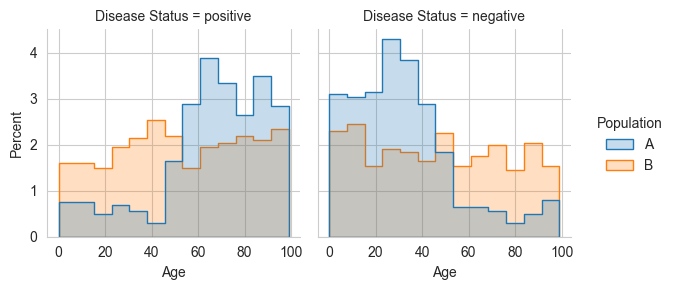

In [5]:
sns.displot(data=data, x="Device Manufacturer", col="Disease Status", hue="Population", element="step", stat="percent", height=3);
sns.displot(data=data, x="Age", col="Disease Status", hue="Population", element="step", stat="percent", height=3);

As indicated in the introduction of this dataset, the population-level attribute distributions of Population A and Population B are similar, and the distributional skews are only evident when the histograms of joint distributions of 2 or more variables are inspected.

While evaluation of joint distribution histograms would reveal this issue, it raises two additional problems:
1. The number of joint distribution histograms quickly increases with the complexity of the dataset
   > For this small dataset, to consider every joint distribution of two attributes would require at least 8 histograms (the 4 shown above and a minimum of 4 to see the joint distributions of Age and Device Manufacturer). The number of required histograms rapidly increases with the number of attributes in a dataset, or if analysis is to be performed on joint distrbutions of more than 2 attributes.
2. Histogram analysis is purely *qualitative*, which can make it difficult to compare across histograms and doesn't allow for the disignation of any definitive threshold to distinguish when two distributions are "similar enough"

## Distributional similarity with DART<a id="dart-1"></a>

In [6]:
# create Dataset object
dataset = DART.Dataset(data)
dataset # display the dataset object to see the attributes

Dataset({'Attributes': ['Age',
                        'Device Manufacturer',
                        'Disease Status',
                        'Population'],
         'Number of samples': 2000})

In [7]:
# compare the distributions of the two populations
comparison = dataset.compare(
    {"Population": "A"},
    {"Population": "B"},
    comparison_type = "individual", # interested in the distributional match of individual attributes
    max_intersectionality_level = 1, # Only interested in the first level of intersectionality (beyond Population)
    subgroup_attributes=["Disease Status", "Device Manufacturer"], # adding Age creates A LOT of intersectional subgroups, an since we're using all but one attribute, we should still catch all of the distributional skews
)
results = pd.DataFrame(comparison.export("tabular"))
display(results)

,subgroup,similarity_from,comparison_level,similarity
0,,Age,0,0.999412
1,,Device Manufacturer,0,0.999588
2,,Disease Status,0,0.998601
3,Disease Status: positive,Age,1,0.955448
4,Disease Status: positive,Device Manufacturer,1,0.986791
5,Disease Status: negative,Age,1,0.945612
6,Disease Status: negative,Device Manufacturer,1,0.979707
7,Device Manufacturer: ii,Age,1,0.997432
8,Device Manufacturer: ii,Disease Status,1,0.978959
9,Device Manufacturer: iv,Age,1,0.999726


In [8]:
results["subgroup_attributes"] = results["subgroup"].apply(lambda subgroup: ", ".join([s.split(":")[0] for s in subgroup.split("; ")]))
results.groupby(["subgroup_attributes", "similarity_from"])["similarity"].agg(["min","max","mean"]).sort_values("mean").reset_index()

,subgroup_attributes,similarity_from,min,max,mean
0,Disease Status,Age,0.945612,0.955448,0.950530
1,Device Manufacturer,Disease Status,0.969347,0.995802,0.983059
2,Disease Status,Device Manufacturer,0.979707,0.986791,0.983249
3,Device Manufacturer,Age,0.996024,0.999726,0.998058
4,,Disease Status,0.998601,0.998601,0.998601
5,,Age,0.999412,0.999412,0.999412
6,,Device Manufacturer,0.999588,0.999588,0.999588


As indicated by the joint distribution histograms, the DART distributional similarity measurements correctly identified the lowest distributional similarity in the joint distribution of Disease Status and Age (row 1), in addition to a slight distributional dissimilarity in the joint distributions of Disease Status and Device Manufacturer (rows 2 and 3). Furthermore, the measurements correctly indicate that the overall population attribute distributions of Population A and Population B are extremely similar, as indicated by similarity values > 0.99 (rows 4-6).

While the similarity value of the joint distributions of Disease Status and Age are *relatively* low when compared to the other distributional similarity measurements taken between Population A and Population B, the values themselves still appear high. This is due to the approximately uniform distribution of all attributes in Population B. An example of a dataset with more extreme distributional dissimilarity can be found in Test 2.

# Test 2: Double population attribute skew
This dataset was generated to simulate a situation in which two populations are being compared (Population A and Population B), but neither can be considered a reference population.
The distribution of Population A is identical to that of Population A in Test 1. The distribution of Population B, however, has been skewed in a nature opposite to that of the distributional skews present in Population A.

Much like in Test 1, it is expected that the distributional skews of our simulated populations will not be obvious from analysis of populaiton-level histograms and will instead require analysis of joint distributions of multiple attributes through the generation of a multitude of histograms, or a quantitative assessment methold such as DART.

In [9]:
# import the dataset
data = pd.read_csv("simulated_datasets/double_population_skew.csv")
# ensure that categorical variables are always shown in the same order in plots
data["Device Manufacturer"] = pd.Categorical(data["Device Manufacturer"], ["i", "ii", "iii", "iv"])
data["Population"] = pd.Categorical(data["Population"], ["A","B"])
data["Disease Status"] = pd.Categorical(data["Disease Status"], ["positive", "negative"])
data.head()

,Population,Device Manufacturer,Disease Status,Age
0,A,ii,positive,79
1,A,ii,negative,39
2,A,ii,positive,91
3,A,iv,positive,85
4,A,iv,positive,92


## Histogram analysis<a id="hist-2"></a>

### Population-level distributions<a id="pop-2"></a>

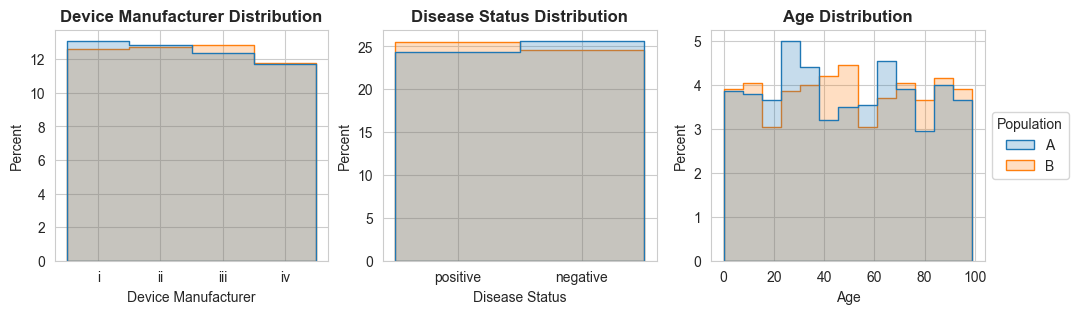

In [10]:
# look at attribute distributions
attributes = [attribute for attribute in data.columns if attribute != "Population"]
fig, axes = plt.subplots(1, len(attributes), figsize=(12,3))
for ii, attribute in enumerate(attributes):
    sns.histplot(data=data, x=attribute, hue="Population", element="step", ax=axes[ii], stat="percent")
    axes[ii].set_title(f"{attribute} Distribution", fontweight="bold")
# only show the legend once
sns.move_legend(axes[-1], "center left", bbox_to_anchor=(1,0.5))
for i in range(len(attributes)-1):
    axes[i].get_legend().remove()

### Joint distributions<a id="joint-2"></a>

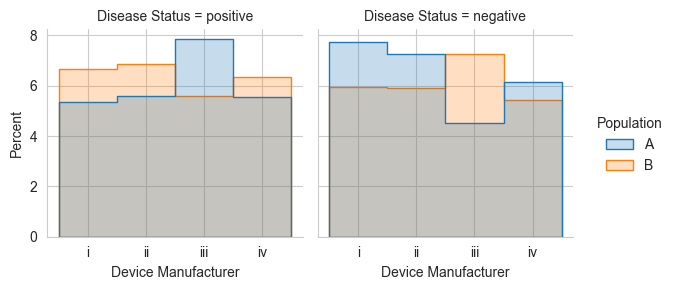

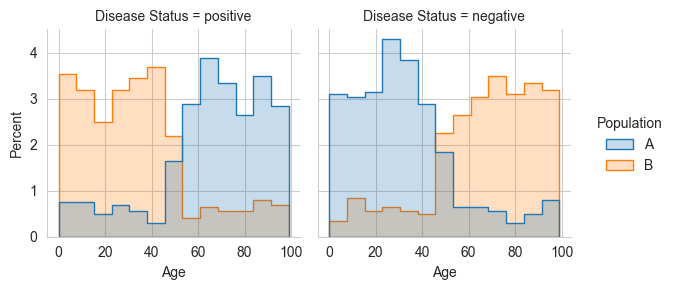

In [11]:
sns.displot(data=data, x="Device Manufacturer", col="Disease Status", hue="Population", element="step", stat="percent", height=3);
sns.displot(data=data, x="Age", col="Disease Status", hue="Population", element="step", stat="percent", height=3);

## Distributional similarity with DART<a id="dart-2"></a>

In [12]:
# create Dataset object
dataset = DART.Dataset(data)
# compare the distributions of the two populations
comparison = dataset.compare(
    {"Population": "A"},
    {"Population": "B"},
    comparison_type = "individual", # interested in the distributional match of individual attributes
    max_intersectionality_level = 1, # Only interested in the first level of intersectionality (beyond Population)
    subgroup_attributes=["Disease Status", "Device Manufacturer"], # adding Age creates A LOT of intersectional subgroups, an since we're using all but one attribute, we should still catch all of the distributional skews
)
results = pd.DataFrame(comparison.export("tabular"))
results["subgroup_attributes"] = results["subgroup"].apply(lambda subgroup: ", ".join([s.split(":")[0] for s in subgroup.split("; ")]))
results.groupby(["subgroup_attributes", "similarity_from"])["similarity"].agg(["min","max","mean"]).sort_values("mean").reset_index()


,subgroup_attributes,similarity_from,min,max,mean
0,Disease Status,Age,0.743724,0.773360,0.758542
1,Disease Status,Device Manufacturer,0.961280,0.972363,0.966821
2,Device Manufacturer,Disease Status,0.926883,0.992229,0.968204
3,Device Manufacturer,Age,0.996024,0.999726,0.998058
4,,Disease Status,0.999071,0.999071,0.999071
5,,Age,0.999412,0.999412,0.999412
6,,Device Manufacturer,0.999588,0.999588,0.999588


As expected, the DART distribution similarity measurements once again indicate the largest amount of distributional misalignment between the joint distributions of Disease Status and Age for Population A and Population B. Furthermore, anticipated decrease in similarity between the joint distributions of Disease Status and Age was observed (decrease to 0.76 from 0.95 in Test 1). This confirms that DART can not only indicate which distributions have the lowest similarity within a dataset, but can also be used to compare the distributional similarity between multiple datasets.